In [ ]:
"""
For the subspace analysis, we have three methods. PCA, cvPCA, and cross-covariance analysis.

Each require the following:
# A recipe to get train and test data
# A recipe to get train place fields
# A way to fit the components
# And a way to measure the variance in the test data

So using a similar structure to the ABC RegressionModel, I can probably define a core structure as follows:

class SubspaceAnalysis:
    def fit(self, session, spks_type): ... # Returns the fit components and extras (data, placefields, etc)
    def score(self, session, fits, spks_type): ... # Returns the variance in the test data
    def reconstruction_score(self, session, fits, spks_type): ... # Returns the frobenius norm of the difference between the test data and the reconstructed data for each expanding subspace
    def get_scores(): ... # A similar cache method for getting scores without dealing with refitting which is slow

Note that I'll also need hyperparameters for measuring the placefields.... unfortunately this isn't just a user choice
because I should probably pick hyperparameters to maximize the variance the placefields explain in temporal data. 

But fortunately with some clever design I can build a structure that will 
allow me to make it easy to add or extend any one of the subspace methods. 
"""
print('bad docstring!')

In [1]:
%reload_ext autoreload
%autoreload 2
# %matplotlib qt
%matplotlib inline

import random
import numpy as np
import torch
from matplotlib import pyplot as plt
from syd import make_viewer, Viewer
from tqdm import tqdm

from vrAnalysis.database import get_database
from vrAnalysis.helpers import Timer, format_spines, beeswarm, errorPlot, save_figure
from vrAnalysis.processors.placefields import get_placefield
from dimilibi import PCA, SVCA
from dimensionality_manuscript.registry import PopulationRegistry, get_subspace, SubspaceName
from dimensionality_manuscript.regression_models.hyperparameters import PlaceFieldHyperparameters

plt.rcParams["font.size"] = 14

# get session database
sessiondb = get_database("vrSessions")

# get population registry and models
registry = PopulationRegistry()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
SUBSPACE_NAMES: list[SubspaceName] = [
    "pca_subspace",
    # "cvpca_subspace",
    "svca_subspace",
    "covcov_subspace",
]
subspaces = [get_subspace(name, registry) for name in SUBSPACE_NAMES]
spks_type = "oasis"
sessiondb = get_database("vrSessions")
registry = PopulationRegistry()

specific_hyperparameters = PlaceFieldHyperparameters(num_bins=100, smooth_width=None)

num_sessions = len(sessiondb.iter_sessions(imaging=True))
mouse_names = []
model_metrics = [[] for _ in subspaces]
for isession, session in enumerate(tqdm(sessiondb.iter_sessions(imaging=True, session_params=dict(spks_type=spks_type)))):
    mouse_names.append(session.mouse_name)
    for imodel, model in enumerate(subspaces):
        metrics = model.get_score(session, spks_type=spks_type, hyperparameters=specific_hyperparameters)
        model_metrics[imodel].append(metrics)
mouse_names = np.array(mouse_names)

score = np.full((len(subspaces), len(mouse_names)), np.nan)
varact, varpos = [], []
for i in range(len(subspaces)):
    c_scores = np.array([m["evaluation_score"] for m in model_metrics[i]])
    c_varact = [m["variance_activity"] for m in model_metrics[i]]
    c_varpos = [m["variance_placefields"] for m in model_metrics[i]]
    score[i] = c_scores
    varact.append(c_varact)
    varpos.append(c_varpos)

num_envs = 3
max_dims = max([len(v) for v in varact[0]+varact[1]])
varact_pad = np.full((len(subspaces), num_envs, len(mouse_names), max_dims), np.nan)
varpos_pad = np.full((len(subspaces), num_envs, len(mouse_names), max_dims), np.nan)
for i in range(len(subspaces)):
    for j in range(len(mouse_names)):
        num_dims = len(varact[i][j])
        idx_env = int(num_dims // 100) - 1
        varact_pad[i, idx_env, j, :len(varact[i][j])] = varact[i][j]
        varpos_pad[i, idx_env, j, :len(varpos[i][j])] = varpos[i][j]

mice = list(set(mouse_names))
avg_scores = np.full((len(SUBSPACE_NAMES), len(mice)), np.nan)
avg_varact = np.full((len(SUBSPACE_NAMES), num_envs, len(mice), max_dims), np.nan)
avg_varpos = np.full((len(SUBSPACE_NAMES), num_envs, len(mice), max_dims), np.nan)
for imodel, model_name in enumerate(SUBSPACE_NAMES):
    for imouse, mouse in enumerate(mice):
        if np.sum(mouse_names == mouse) == 0:
            print(f"No sessions for {mouse} with model {model_name}")
        avg_scores[imodel, imouse] = np.mean(score[imodel][mouse_names == mouse])
        avg_varact[imodel, :, imouse] = np.nanmean(varact_pad[imodel][:, mouse_names == mouse], axis=1)
        avg_varpos[imodel, :, imouse] = np.nanmean(varpos_pad[imodel][:, mouse_names == mouse], axis=1)

100%|██████████| 149/149 [00:02<00:00, 55.33it/s]
C:\Users\Andrew\AppData\Local\Temp\ipykernel_28204\764729280.py:54: RuntimeWarning: Mean of empty slice
  avg_varact[imodel, :, imouse] = np.nanmean(varact_pad[imodel][:, mouse_names == mouse], axis=1)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_28204\764729280.py:55: RuntimeWarning: Mean of empty slice
  avg_varpos[imodel, :, imouse] = np.nanmean(varpos_pad[imodel][:, mouse_names == mouse], axis=1)


In [12]:
idxmodel0 = 0
idxmodel1 = 2

class SubspaceViewer(Viewer):
    def __init__(self):
        self.add_integer("idx_mouse", min=0, max=len(mice)-1)
        self.add_integer("num_envs", min=1, max=num_envs)
        self.add_selection("plot_type", options=["both", "difference"])
        self.add_selection("data_type", options=["cumvariance", "variance"])
        self.add_selection("xscale", options=["linear", "log"])
        self.add_selection("yscale", options=["linear", "log"])
        self.add_boolean("normalize", value=True)
        self.add_boolean("all", value=True)

    def plot(self, state):
        idx_env = state["num_envs"] - 1
        if state["all"]:
            data_activity = avg_varact[:, idx_env]
            data_placefields = avg_varpos[:, idx_env]
            if state["normalize"]:
                total_variance = np.nansum(data_activity, axis=2, keepdims=True)
                data_activity = data_activity / total_variance
                data_placefields = data_placefields / total_variance
            if state["data_type"] == "cumvariance":
                data_activity = np.cumsum(data_activity, axis=2)
                data_placefields = np.cumsum(data_placefields, axis=2)
                
        else:
            idx_mouse = state["idx_mouse"]
            data_activity = avg_varact[:, idx_env, idx_mouse]
            data_placefields = avg_varpos[:, idx_env, idx_mouse]
            if state["normalize"]:
                total_variance = np.nansum(data_activity, axis=1, keepdims=True)
                data_activity = data_activity / total_variance
                data_placefields = data_placefields / total_variance

            if state["data_type"] == "cumvariance":
                data_activity = np.cumsum(data_activity, axis=1)
                data_placefields = np.cumsum(data_placefields, axis=1)

        fig, ax = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")
        if state["all"]:
            if state["plot_type"] == "difference":
                difference = data_activity - data_placefields
                ax[0].plot(range(1, max_dims+1), difference[idxmodel0].T, color="k", alpha=0.25)
                ax[1].plot(range(1, max_dims+1), difference[idxmodel1].T, color="k", alpha=0.25)
                ax[0].plot(range(1, max_dims+1), np.nanmean(difference[idxmodel0], axis=0), color="k")
                ax[1].plot(range(1, max_dims+1), np.nanmean(difference[idxmodel1], axis=0), color="k")
            elif state["plot_type"] == "both":
                ax[0].plot(range(1, max_dims+1), data_activity[idxmodel0].T, color="k", alpha=0.25)
                ax[0].plot(range(1, max_dims+1), data_placefields[idxmodel0].T, color="b", alpha=0.25)
                ax[1].plot(range(1, max_dims+1), data_activity[idxmodel1].T, color="k", alpha=0.25)
                ax[1].plot(range(1, max_dims+1), data_placefields[idxmodel1].T, color="b", alpha=0.25)

                ax[0].plot(range(1, max_dims+1), np.nanmean(data_activity[idxmodel0], axis=0), color="k")
                ax[0].plot(range(1, max_dims+1), np.nanmean(data_placefields[idxmodel0], axis=0), color="b")
                ax[1].plot(range(1, max_dims+1), np.nanmean(data_activity[idxmodel1], axis=0), color="k")
                ax[1].plot(range(1, max_dims+1), np.nanmean(data_placefields[idxmodel1], axis=0), color="b")

                ax[0].set_title(f"{np.nansum(data_activity[idxmodel0])}")
                ax[1].set_title(f"{np.nansum(data_activity[idxmodel1])}")
        else:
            if state["plot_type"] == "difference":
                ax[0].plot(range(1, max_dims+1), data_activity[idxmodel0] - data_placefields[idxmodel0], color="k")
                ax[1].plot(range(1, max_dims+1), data_activity[idxmodel1] - data_placefields[idxmodel1], color="k")
            elif state["plot_type"] == "both":
                ax[0].plot(range(1, max_dims+1), data_activity[idxmodel0], color="k")
                ax[0].plot(range(1, max_dims+1), data_placefields[idxmodel0], color="b")
                ax[1].plot(range(1, max_dims+1), data_activity[idxmodel1], color="k")
                ax[1].plot(range(1, max_dims+1), data_placefields[idxmodel1], color="b")
                ax[0].set_title(f"{np.nansum(data_activity[idxmodel0])}")
                ax[1].set_title(f"{np.nansum(data_activity[idxmodel1])}")
        ax[0].set_xscale(state["xscale"])
        ax[1].set_xscale(state["xscale"])
        ax[0].set_yscale(state["yscale"])
        ax[1].set_yscale(state["yscale"])
        return fig

viewer = SubspaceViewer()
viewer.show()

C:\Users\Andrew\AppData\Local\Temp\ipykernel_28204\2002938533.py:55: RuntimeWarning: Mean of empty slice
  ax[0].plot(range(1, max_dims+1), np.nanmean(data_activity[idxmodel0], axis=0), color="k")
C:\Users\Andrew\AppData\Local\Temp\ipykernel_28204\2002938533.py:56: RuntimeWarning: Mean of empty slice
  ax[0].plot(range(1, max_dims+1), np.nanmean(data_placefields[idxmodel0], axis=0), color="b")
C:\Users\Andrew\AppData\Local\Temp\ipykernel_28204\2002938533.py:57: RuntimeWarning: Mean of empty slice
  ax[1].plot(range(1, max_dims+1), np.nanmean(data_activity[idxmodel1], axis=0), color="k")
C:\Users\Andrew\AppData\Local\Temp\ipykernel_28204\2002938533.py:58: RuntimeWarning: Mean of empty slice
  ax[1].plot(range(1, max_dims+1), np.nanmean(data_placefields[idxmodel1], axis=0), color="b")


C:\Users\Andrew\Documents\GitHub\vrAnalysis\vrAnalysis\helpers\plotting.py:80: RuntimeWarning: Mean of empty slice
  meanData = mean(data, axis=axis)
c:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0.3280520849866721
0.40398337737766843
0.4222799804554356


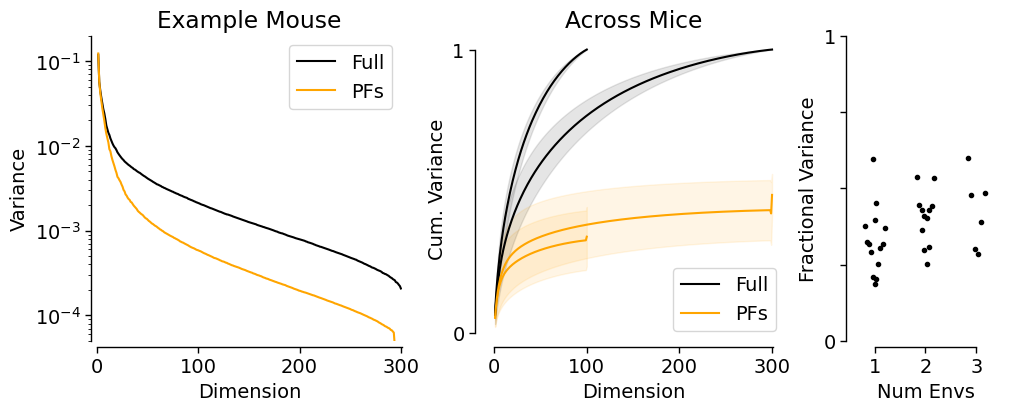

In [24]:
total_variance = np.nansum(avg_varact, axis=3, keepdims=True)
norm_data_activity = avg_varact / total_variance
norm_data_placefields = avg_varpos / total_variance

csnorm_data_activity = np.cumsum(norm_data_activity, axis=3)
csnorm_data_placefields = np.cumsum(norm_data_placefields, axis=3)


idx_model = 2 # Use the COVCOV model
idx_mouse = 6 
beewidth = 0.2
full_color = "black"
placefield_color = "orange"
        
xlim = (0, max_dims+1)
ylim = (5e-5, 2e-1)
xticks = [0, 100, 200, 300]

plt.close('all')
fig, ax = plt.subplots(1, 3, figsize=(10, 4), width_ratios=[2, 2, 1], layout="constrained")
need_label = True
for inumenv in [2]:
    ax[0].plot(range(1, max_dims+1), norm_data_activity[idx_model, inumenv, idx_mouse].T, color=full_color, label="Full" if need_label else None)
    ax[0].plot(range(1, max_dims+1), norm_data_placefields[idx_model, inumenv, idx_mouse].T, color=placefield_color, label="PFs" if need_label else None)
    need_label = False
ax[0].set_xlabel("Dimension")
ax[0].set_ylabel("Variance")
ax[0].legend(loc="upper right")
ax[0].set_title("Example Mouse")
ax[0].set_yscale('log')
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
format_spines(ax[0], x_pos=-0.02, y_pos=-0.02, xbounds=xlim, xticks=xticks, ybounds=ylim)


ylim = (0, 1)
need_label = True
for inumenv in [0, 2]:
    errorPlot(range(1, max_dims+1), csnorm_data_activity[idx_model, inumenv], axis=0, ax=ax[1], se=False, color=full_color, label="Full" if need_label else None, alpha=0.1)
    errorPlot(range(1, max_dims+1), csnorm_data_placefields[idx_model, inumenv], axis=0, ax=ax[1], se=False, color=placefield_color, label="PFs" if need_label else None, alpha=0.1)
    need_label = False
ax[1].set_xlabel("Dimension")
ax[1].set_ylabel("Cum. Variance")
ax[1].legend(loc="lower right")
ax[1].set_title("Across Mice")
format_spines(ax[1], x_pos=-0.02, y_pos=-0.02, xbounds=xlim, xticks=xticks, ybounds=ylim, yticks=ylim)

show_envs = [0, 1, 2]
xbounds = (0, len(show_envs)-1)
xlim = (-0.5, len(show_envs)-0.5)
ylim = (0, 1)
for ii, idx in enumerate(show_envs):
    ilast = (idx + 1) * 100 - 1
    c_data_activity = csnorm_data_activity[idx_model, idx, :, ilast - 1]
    c_data_placefields = csnorm_data_placefields[idx_model, idx, :, ilast - 1]
    c_fraction = c_data_placefields / c_data_activity
    c_valid_fraction = c_fraction[~np.isnan(c_fraction)]
    print(np.mean(c_valid_fraction))
    ax[2].plot(ii + beewidth*beeswarm(c_valid_fraction), c_valid_fraction, color=full_color, marker=".", linestyle="none", label="Full")
ax[2].set_xlim(xlim)
ax[2].set_ylim(ylim)
ax[2].set_xlabel("Num Envs")
ax[2].set_ylabel("Fractional Variance")
format_spines(ax[2], x_pos=-0.02, y_pos=-0.02, xbounds=xbounds, ybounds=ylim)
ax[2].set_xticks(range(len(show_envs)))
ax[2].set_xticklabels([f"{idx + 1}" for idx in show_envs])
ax[2].set_yticks([0, 0.25, 0.5, 0.75, 1])
ax[2].set_yticklabels([0, '', '', '', 1])

model_name = {
    0: "pca",
    1: "svca",
    2: "covcov",
}
figure_path = registry.registry_paths.figure_path / "subspace_analysis" / f"{model_name[idx_model]}_subspace_basic_figure"
# save_figure(fig, figure_path)

plt.show()

In [ ]:
# This code block runs the PCA version of the subspace analysis
# It estimates the primary modes of variance using the train split for both the 
# full activity and the place fields. Then, it measures the variance within those
# modes on the test split data - where we project the full activity in test on 
# either the PCs from the train full data or the PCs from the train place fields. 

session = random.choice(sessiondb.iter_sessions(imaging=True, session_params=dict(spks_type="oasis")))
print(session)

center = False # don't think this matters much
train_split = registry.time_split["half0"]
test_split = registry.time_split["half1"]
population, frame_behavior = registry.get_population(session, spks_type="oasis")

num_neurons = len(population.idx_neurons)
train_data = population.apply_split(population.data[population.idx_neurons], train_split, prefiltered=False)
test_data = population.apply_split(population.data[population.idx_neurons], test_split, prefiltered=False)
frame_behavior_train = frame_behavior.filter(population.get_split_times(train_split, within_idx_samples=False))

if center:
    train_data = train_data - train_data.mean(dim=1, keepdim=True)
    test_data = test_data - test_data.mean(dim=1, keepdim=True)

num_bins = 100
dist_edges = np.linspace(0, session.env_length[0], num_bins+1)
placefield = get_placefield(
    train_data.T.numpy(),
    frame_behavior_train,
    dist_edges=dist_edges,
    average=True,
    smooth_width=5.0,
)
placefield_extended = torch.tensor(placefield.placefield).reshape(-1, num_neurons).T

num_components = min(400, *train_data.shape, *test_data.shape, *placefield_extended.shape)
pca_all = PCA(num_components=num_components).fit(train_data)
pca_pos = PCA(num_components=num_components).fit(placefield_extended)  

train_data = train_data
test_data = test_data
components_all = pca_all.get_components()
components_pos = pca_pos.get_components()
train_variance_all = torch.var(train_data.T @ components_all, dim=0)
test_variance_all = torch.var(test_data.T @ components_all, dim=0)
train_variance_pos = torch.var(train_data.T @ components_pos, dim=0)
test_variance_pos = torch.var(test_data.T @ components_pos, dim=0)

# # Measure reconstruction error for expanding subspaces
# reconstruction_error_all = torch.zeros(num_components)
# reconstruction_error_pos = torch.zeros(num_components)
# for i in tqdm(range(num_components)):
#     c_comp_all = components_all[:, :i+1]
#     c_comp_pos = components_pos[:, :i+1]
#     recon_all = c_comp_all @ c_comp_all.T @ test_data
#     recon_pos = c_comp_pos @ c_comp_pos.T @ test_data
#     error_all = torch.norm(test_data - recon_all)
#     error_pos = torch.norm(test_data - recon_pos)
#     reconstruction_error_all[i] = error_all
#     reconstruction_error_pos[i] = error_pos

plt.close('all')
fig, ax = plt.subplots(3, 2, figsize=(10, 8), layout="constrained")
ax[0, 0].plot(train_variance_all.cpu(), c='k', label="Train Full")
ax[0, 0].plot(test_variance_all.cpu(), c='b', label="Test Full")
ax[0, 0].set_title("Comparing Train vs Test Full\nVariance")
ax[0, 0].legend(loc="upper right")
ax[1, 0].plot(torch.cumsum(train_variance_all.cpu(), dim=0), c='k')
ax[1, 0].plot(torch.cumsum(test_variance_all.cpu(), dim=0), c='b')
ax[1, 0].set_title("Cumulative variance")
ax[2, 0].plot(torch.cumsum(test_variance_all.cpu(), dim=0) / torch.cumsum(train_variance_all.cpu(), dim=0), c='b')
ax[2, 0].set_title("Subspace Ratio")

ax[0, 1].plot(test_variance_all.cpu(), c='b', label="Test Full")
ax[0, 1].plot(test_variance_pos.cpu(), c='g', label="Test Placefields")
ax[0, 1].set_title("Comparing Test Full vs Test Placefields\nVariance")
ax[0, 1].legend(loc="upper right")
ax[1, 1].plot(torch.cumsum(test_variance_all.cpu(), dim=0), c='b')
ax[1, 1].plot(torch.cumsum(test_variance_pos.cpu(), dim=0), c='g')
ax[1, 1].set_title("Cumulative variance")
ax[2, 1].plot(torch.cumsum(test_variance_pos.cpu(), dim=0) / torch.cumsum(test_variance_all.cpu(), dim=0), c='g')
ax[2, 1].set_title("Subspace Ratio")
plt.show()

In [ ]:
# This code block runs the cv PCA version of the subspace analysis
# session = random.choice(sessiondb.iter_sessions(imaging=True, session_params=dict(spks_type="oasis")))
print(session)

train0_split = registry.time_split["train0"]
train1_split = registry.time_split["train1"]
test_split = registry.time_split["not_train"]
population, frame_behavior = registry.get_population(session, spks_type="oasis")

num_neurons = len(population.idx_neurons)
train0_data = population.apply_split(population.data[population.idx_neurons], train0_split, prefiltered=False)
train1_data = population.apply_split(population.data[population.idx_neurons], train1_split, prefiltered=False)
test_data = population.apply_split(population.data[population.idx_neurons], test_split, prefiltered=False)
frame_behavior_train0 = frame_behavior.filter(population.get_split_times(train0_split, within_idx_samples=False))
frame_behavior_train1 = frame_behavior.filter(population.get_split_times(train1_split, within_idx_samples=False))

if train0_data.shape[1] != train1_data.shape[1]:
    num_samples = min(train0_data.shape[1], train1_data.shape[1])
    idx_train0 = np.sort(np.random.choice(train0_data.shape[1], num_samples, replace=False))
    idx_train1 = np.sort(np.random.choice(train1_data.shape[1], num_samples, replace=False))
    train0_data = train0_data[:, idx_train0]
    train1_data = train1_data[:, idx_train1]
    frame_behavior_train0 = frame_behavior_train0.filter(idx_train0)
    frame_behavior_train1 = frame_behavior_train1.filter(idx_train1)

num_bins = 100
dist_edges = np.linspace(0, session.env_length[0], num_bins+1)
placefield0 = get_placefield(
    train0_data.T.numpy(),
    frame_behavior_train0,
    dist_edges=dist_edges,
    average=True,
    smooth_width=5.0,
)
placefield1 = get_placefield(
    train1_data.T.numpy(),
    frame_behavior_train1,
    dist_edges=dist_edges,
    average=True,
    smooth_width=5.0,
)
placefield0_extended = torch.tensor(placefield0.placefield).reshape(-1, num_neurons).T
placefield1_extended = torch.tensor(placefield1.placefield).reshape(-1, num_neurons).T

num_components = min(400, *train0_data.shape, *train1_data.shape, *test_data.shape, *placefield0_extended.shape, *placefield1_extended.shape)

centered = True
svca_all = SVCA(centered=centered, num_components=num_components)
svca_all = svca_all.fit(train0_data, train1_data)
svca_pos = SVCA(centered=centered, num_components=num_components)
svca_pos = svca_pos.fit(placefield0_extended, placefield1_extended)

components_all = svca_all.U
components_pos = svca_pos.U
train_variance_all = torch.var(train_data.T @ components_all, dim=0)
test_variance_all = torch.var(test_data.T @ components_all, dim=0)
train_variance_pos = torch.var(train_data.T @ components_pos, dim=0)
test_variance_pos = torch.var(test_data.T @ components_pos, dim=0)
plt.close('all')
fig, ax = plt.subplots(3, 2, figsize=(10, 8), layout="constrained")
ax[0, 0].plot(train_variance_all, c='k', label="Train Full")
ax[0, 0].plot(test_variance_all, c='b', label="Test Full")
ax[0, 0].set_title("Comparing Train vs Test Full\nVariance")
ax[0, 0].legend(loc="upper right")
ax[1, 0].plot(torch.cumsum(train_variance_all, dim=0), c='k')
ax[1, 0].plot(torch.cumsum(test_variance_all, dim=0), c='b')
ax[1, 0].set_title("Cumulative variance")
ax[2, 0].plot(torch.cumsum(test_variance_all, dim=0) / torch.cumsum(train_variance_all, dim=0), c='b')
ax[2, 0].set_title("Subspace Ratio")

ax[0, 1].plot(test_variance_all, c='b', label="Test Full")
ax[0, 1].plot(test_variance_pos, c='g', label="Test Placefields")
ax[0, 1].set_title("Comparing Test Full vs Test Placefields\nVariance")
ax[0, 1].legend(loc="upper right")
ax[1, 1].plot(torch.cumsum(test_variance_all, dim=0), c='b')
ax[1, 1].plot(torch.cumsum(test_variance_pos, dim=0), c='g')
ax[1, 1].set_title("Cumulative variance")
ax[2, 1].plot(torch.cumsum(test_variance_pos, dim=0) / torch.cumsum(test_variance_all, dim=0), c='g')
ax[2, 1].set_title("Subspace Ratio")
plt.show()

In [ ]:
components_all = svca_all.U
components_pos = svca_pos.U
train_variance_all = torch.var(train0_data.T @ components_all, dim=0)
test_variance_all = torch.var(test_data.T @ components_all, dim=0)
train_variance_pos = torch.var(train0_data.T @ components_pos, dim=0)
test_variance_pos = torch.var(test_data.T @ components_pos, dim=0)
plt.close('all')
fig, ax = plt.subplots(3, 2, figsize=(10, 8), layout="constrained")
ax[0, 0].plot(train_variance_all, c='k')
ax[0, 0].plot(test_variance_all, c='b')
ax[0, 0].set_title("Comparing Train vs Test Full\nVariance")
ax[1, 0].plot(torch.cumsum(train_variance_all, dim=0), c='k')
ax[1, 0].plot(torch.cumsum(test_variance_all, dim=0), c='b')
ax[1, 0].set_title("Cumulative variance")
ax[2, 0].plot(torch.cumsum(test_variance_all, dim=0) / torch.cumsum(train_variance_all, dim=0), c='b')
ax[2, 0].set_title("Subspace Ratio")

ax[0, 1].plot(test_variance_all, c='b')
ax[0, 1].plot(test_variance_pos, c='g')
ax[0, 1].set_title("Comparing Test Full vs Test Placefields\nVariance")
ax[1, 1].plot(torch.cumsum(test_variance_all, dim=0), c='b')
ax[1, 1].plot(torch.cumsum(test_variance_pos, dim=0), c='g')
ax[1, 1].set_title("Cumulative variance")
ax[2, 1].plot(torch.cumsum(test_variance_pos, dim=0) / torch.cumsum(test_variance_all, dim=0), c='g')
ax[2, 1].set_title("Subspace Ratio")
plt.show()

In [ ]:
# This code block runs the SVCA version of the subspace analysis

# session = random.choice(sessiondb.iter_sessions(imaging=True, session_params=dict(spks_type="oasis")))
print(session)

train_split = registry.time_split["half0"]
test_split = registry.time_split["half1"]
population, frame_behavior = registry.get_population(session, spks_type="oasis")

num_source_neurons = len(population.cell_split_indices[0])
num_target_neurons = len(population.cell_split_indices[1])
train_source, train_target = population.get_split_data(train_split)
test_source, test_target = population.get_split_data(test_split)
frame_behavior_train = frame_behavior.filter(population.get_split_times(train_split, within_idx_samples=False))

num_bins = 100
dist_edges = np.linspace(0, session.env_length[0], num_bins+1)
placefield_source = get_placefield(
    train_source.T.numpy(),
    frame_behavior_train,
    dist_edges=dist_edges,
    average=True,
    smooth_width=5.0,
)
placefield_target = get_placefield(
    train_target.T.numpy(),
    frame_behavior_train,
    dist_edges=dist_edges,
    average=True,
    smooth_width=5.0,
)
placefield_source_extended = torch.tensor(placefield_source.placefield).reshape(-1, num_source_neurons).T
placefield_target_extended = torch.tensor(placefield_target.placefield).reshape(-1, num_target_neurons).T

num_components = min(*train_source.shape, *train_target.shape, *placefield_source_extended.shape, *placefield_target_extended.shape)

centered = True
svca_all = SVCA(centered=centered, num_components=num_components)
svca_all = svca_all.fit(train_source, train_target)
svca_pos = SVCA(centered=centered, num_components=num_components)
svca_pos = svca_pos.fit(placefield_source_extended, placefield_target_extended)

sv_all_train = svca_all.score(train_source, train_target)[0]
sv_all_test = svca_all.score(test_source, test_target)[0]
sv_pos_train = svca_pos.score(train_source, train_target)[0]
sv_pos_test = svca_pos.score(test_source, test_target)[0]

plt.close('all')
fig, ax = plt.subplots(3, 2, figsize=(10, 8), layout="constrained")
ax[0, 0].plot(sv_all_train, c='k', label="Train Full")
ax[0, 0].plot(sv_all_test, c='b', label="Test Full")
ax[0, 0].set_title("Comparing Train vs Test Full\nVariance")
ax[0, 0].legend(loc="upper right")
ax[1, 0].plot(torch.cumsum(sv_all_train, dim=0), c='k')
ax[1, 0].plot(torch.cumsum(sv_all_test, dim=0), c='b')
ax[1, 0].set_title("Cumulative variance")
ax[2, 0].plot(torch.cumsum(sv_all_test, dim=0) / torch.cumsum(sv_all_train, dim=0), c='b')
ax[2, 0].set_title("Subspace Ratio")

ax[0, 1].plot(sv_all_test, c='b', label="Test Full")
ax[0, 1].plot(sv_pos_test, c='g', label="Test Placefields")
ax[0, 1].set_title("Comparing Test Full vs Test Placefields\nVariance")
ax[0, 1].legend(loc="upper right")
ax[1, 1].plot(torch.cumsum(sv_all_test, dim=0), c='b')
ax[1, 1].plot(torch.cumsum(sv_pos_test, dim=0), c='g')
ax[1, 1].set_title("Cumulative variance")
ax[2, 1].plot(torch.cumsum(sv_pos_test, dim=0) / torch.cumsum(sv_all_test, dim=0), c='g')
ax[2, 1].set_title("Subspace Ratio")
plt.show()

In [ ]:
# This block runs a simulation for how the PCA version of the subspace analysis will work if 
# the train and test data are generated from slightly different subspaces. 

num_samples = 100000
num_neurons = 100
num_components = 100

# Generate eigenspectrum
eigenvalues = 1.2 ** -torch.arange(num_components)
same_fraction = 0.5
_ev_shared = torch.randn(num_neurons, num_neurons)
eigenvectors_train = torch.linalg.qr(same_fraction * _ev_shared + (1-same_fraction) * torch.randn(num_neurons, num_neurons)).Q[:, :num_components]
eigenvectors_test = torch.linalg.qr(same_fraction * _ev_shared + (1-same_fraction) * torch.randn(num_neurons, num_neurons)).Q[:, :num_components]

# Generate random data
train_data = eigenvectors_train @ torch.diag(torch.sqrt(eigenvalues)) @ torch.randn(num_components, num_samples)
test_data = eigenvectors_test @ torch.diag(torch.sqrt(eigenvalues)) @ torch.randn(num_components, num_samples)

# Measure the eigenspectrum of the data
train_data_cov = train_data @ train_data.T / num_samples
eigenvalues_train, _ = torch.linalg.eigh(train_data_cov)
eigenvalues_train = torch.flip(eigenvalues_train, dims=(0,))

# Plot eigenspectrum
plt.close('all')
plt.plot(eigenvalues, c='k')
plt.plot(eigenvalues_train, c='b')
plt.show()

# Now run PCA on train data and measure total variance in each expanding subspace of test data
train_pca = PCA(num_components=num_components).fit(train_data)

# Then go and measure the total variance in each expanding subspace of test data
components = train_pca.get_components()
cv_variance = torch.zeros(num_components)
exp_variance = torch.zeros(num_components)
for i in tqdm(range(num_components)):
    exp_variance[i] = torch.var(components[:, :i+1].T @ train_data, dim=1).sum()
    cv_variance[i] = torch.var(components[:, :i+1].T @ test_data, dim=1).sum()
    
# If the subspaces differ, the blue curve should take a while to catch up to the black curve. 
plt.close('all')
plt.plot(exp_variance+2, c='k')
plt.plot(cv_variance+2, c='b')
plt.show()